Explore Results of Model

In [1]:
import pandas as pd
import glob
import os
import numpy as np
  
# merging the files
#joined_files = os.path.join("results", "station*.csv")
joined_files = "../data/results/nested*.csv"
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
  
# Finally, the files are joined
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)


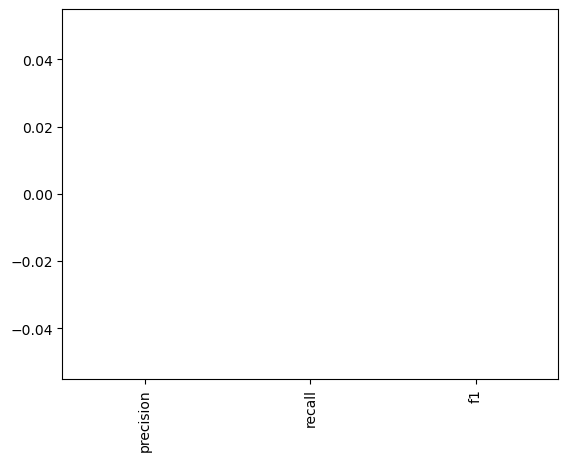

In [2]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
for aug in [True,False]:
    df[(df.feature=='all') & (df.augment==aug)][['precision','recall','f1']].mean().plot.bar(ax=ax)

(0.6, 1.0)

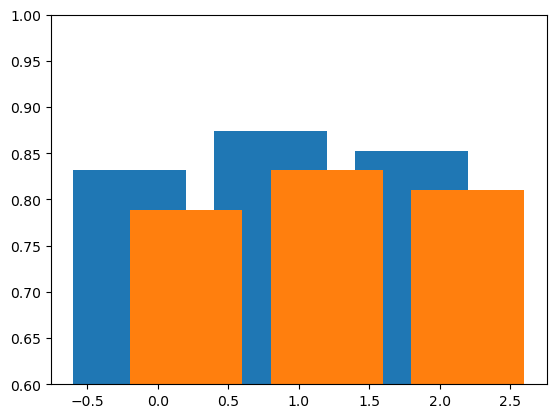

In [6]:
x = np.arange(3)
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
for aug, offs in zip([True,False],[-.2,.2]):
    ax.bar(x+offs,df[(df.feature=='all') & (df.augment==aug)][['precision','recall','f1']].mean())
ax.set_ylim([.6,1])

In [27]:
x

array([0, 1])

In [30]:
df[(df.feature=='all') & (df.augment==aug)][['precision','recall','f1']].mean()

precision    0.800852
recall       0.695360
f1           0.734820
dtype: float64